# Building LRG Templates

**ToDo: Update to DR5**

The goal of this notebook is to use observations of a large number of luminous red galaxies (LRGs) with DECaLS/DR3 *grzW1W2* photometry and ancillary spectroscopic redshifts to generate a set of spectroscopic templates suitable for spectroscopic simulations, targeting investigations, and other DESI-related projects.

The parent sample consists of 2,511,248 LRGs selected from the official DECaLS/DR3.1 target catalog `targets-dr3.1-0.14.0.fits` using the selection criterion
```python
DESI_TARGET & desi_mask.LRG != 0
```

Subsequently, Rongpu Zhou (Pittsburgh) assembled spectroscopic redshifts for the sample from SDSS/Main, SDSS/BOSS, AGES, DEEP2, and VIPERS, supplemented with COSMOS medium-band photometric redshifts, yielding precise redshifts for 62,177 objects (2.4% of the parent sample).  Using these data, Zhou used a random forest technique (described elsewhere) to compute photometric redshifts for the complete sample, producing the catalog `dr3.1-0.14.0-lrg-rf-photoz-0.2.fits`, which we use as input into the generation of the spectral templates.

Specifically, we generate templates using the following procedure:
  1.  We focus exclusively on the subset of 62,177 LRGs with spectroscopic redshifts since we find that the training sample is fairly representative of the full sample in the four-dimensional space of *g-r*, *r-z*, *z*-band magnitude, and redshift.  (Future versions of these templates may utilize the random forest photometric redshifts.)
  2. We use the Bayesian spectral energy distribution (SED) modeling code [iSEDfit](http://www.sos.siena.edu/~jmoustakas/isedfit) and the CKC14z simple stellar population models of Conroy et al. to model the observed SEDs of the parent sample of galaxies.  The outputs of this code are the best-fitting (maximum likelihood) spectroscopic template and the marginalized posterior distributions on a large number of quantities of interest, stored in the file `legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits`.  In addition, we compute K-corrected absolute magnitudes in the DECaLS *g*-, *r*-, and *z*-band bandpasses and store them in the file `legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits`.
  3. Next, we select a quasi-representative subset of these models for use as basis templates using a simple kd-tree built from the rest-frame 

John Moustakas
Siena College
2017 September 21

### Preliminaries

In [1]:
import os
import numpy as np

from astropy.table import Table
from scipy.spatial import cKDTree as KDTree

In [2]:
import matplotlib.pyplot as plt
from corner import corner

In [3]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [4]:
isedfit_version = 'v1.0'
templates_version = 'v2.0'

In [5]:
isedfit_dir = os.path.join(os.getenv('DESI_ROOT'), 'spectro', 'templates', 'lrg_templates', 'isedfit', isedfit_version)

### Read the iSEDfit and absolute magnitude catalogs.

In [ ]:
ised = Table.read(os.path.join(isedfit_dir, 'legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz'))

In [53]:
np.count_nonzero()

62140

In [128]:
def read_isedfit():
    """Read the iSEDfit fitting results."""
    
    isedfile = os.path.join(isedfit_dir, 'legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz')
    kcorrfile = os.path.join(isedfit_dir, 'legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits.gz')

    print('Reading {}'.format(isedfile))
    ised = Table.read(isedfile)
    print('Reading {}'.format(kcorrfile))
    kcorr = Table.read(kcorrfile)
    
    snrmin = 3.0
    chi2min = 10
    
    keep = np.where(
        (ised['CHI2'] < chi2min) * 
        (np.sum(ised['MAGGIES'] * np.sqrt(ised['IVARMAGGIES']) > snrmin, axis=1) == 5)
    )[0]
    print('Read {} galaxies with chi2 < {} and S/N > {} in all 5 bands.'.format(len(keep), chi2min, snrmin))
    
    cat = dict()
    cat['redshift'] = kcorr['Z'][keep].data
    cat['Mstar'] = ised['MSTAR_50'][keep].data
    cat['Mg'] = kcorr['ABSMAG'][keep, 0].data
    cat['Mr'] = kcorr['ABSMAG'][keep, 1].data
    cat['Mz'] = kcorr['ABSMAG'][keep, 2].data
    cat['gr'] = cat['Mg'] - cat['Mr']
    cat['rz'] = cat['Mr'] - cat['Mz']

    with np.errstate(invalid='ignore'):
        cat['grobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 0].data / ised['MAGGIES'][keep, 1].data )
        cat['rzobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 1].data / ised['MAGGIES'][keep, 2].data )
        cat['zW1obs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 2].data / ised['MAGGIES'][keep, 3].data )
     
    #mm = - 2.5 * np.log10(ised['MAGGIES'][keep, 0].data)
    #_ = plt.hist(mm, bins=100)
    
    return cat

In [129]:
cat = read_isedfit()
ngal = len(cat['redshift'])

Reading /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v1.0/legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01.fits.gz
Reading /Users/ioannis/work/desi/spectro/templates/lrg_templates/isedfit/v1.0/legacysurvey_lrg_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits.gz
Read 48760 galaxies with chi2 < 10 and S/N > 3.0 in all 5 bands.


### Visualize the sample in rest-frame color-color-magnitude-redshift space.

In [130]:
zlim, Mzlim, grlim, rzlim = (0, 1), (-21, -26), (0.2, 1.2), (0.2, 0.8)

In [134]:
def qa_restcorner():
    fig = corner(np.vstack((cat['redshift'], cat['Mz'], cat['gr'], cat['rz'])).T, 
                 labels=('Redshift', r'$M_{0.0z}$', r'$^{0.0}(g - r)$', r'$^{0.0}(r - z)$'),
                 range=(zlim, Mzlim, grlim, rzlim))

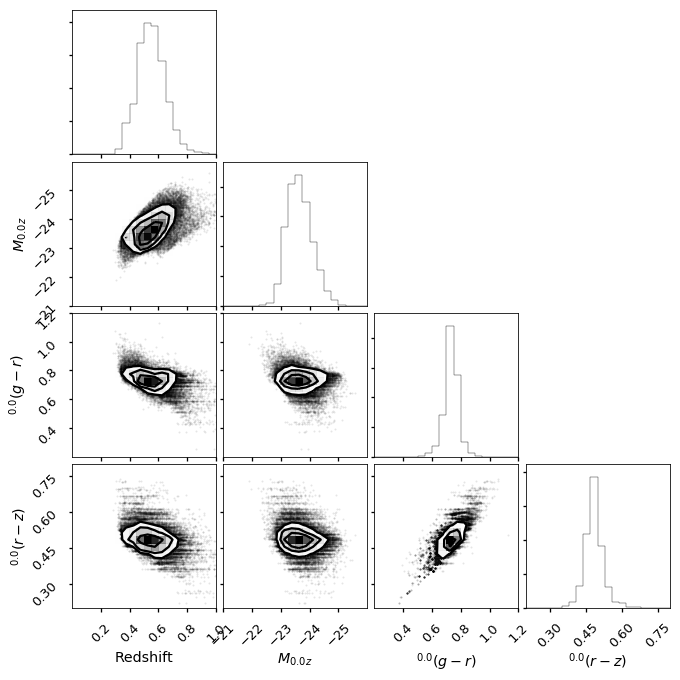

In [135]:
qa_restcorner()

#### Now in observed color-color space.

In [132]:
grobslim, rzobslim = (0, 5), (-0.5, 2.5)

In [139]:
def qa_colorcolor_obs():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.scatter(cat['rzobs'], cat['grobs'], s=3, alpha=0.9)
    ax1.set_xlabel(r'$(r - z)_{\rm obs}$')
    ax1.set_ylabel(r'$(g - r)_{\rm obs}$')
    
    ax2.scatter(cat['rzobs'], cat['zW1obs'], s=3, alpha=0.9)
    ax2.set_ylabel(r'$(r - z)_{\rm obs}$')
    ax2.set_xlabel(r'$(z - W1)_{\rm obs}$')

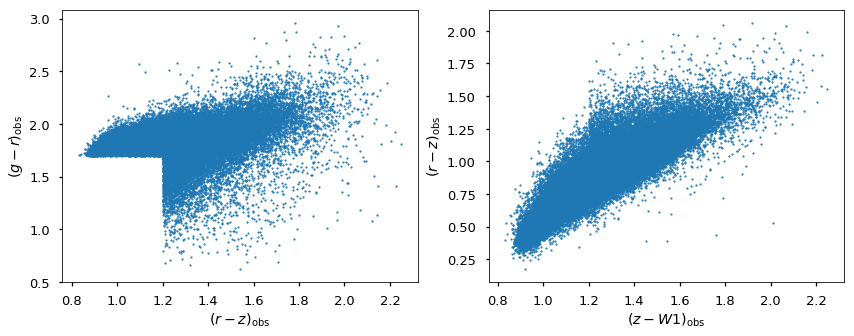

In [140]:
qa_colorcolor_obs()

### Group like templates.

Based on the preceding corner plot, the rest-frame colors depend only very weakly on either redshift or absolute magnitude (owing to the relative homogeneity of the population).  Consequently, use just (g-r) and (r-z) color to group "like" galaxies into fixed (rectangular) bins.

In [141]:
def group_templates(x_in, lim_in):
    """Use scipy's binned_statistic_dd method to assigned galaxies to 
    fixed input bins.    
    """
    from scipy.stats import binned_statistic_dd
    
    lim = (grlim, rzlim)
    delta = (0.02, 0.02)
    nbins = [np.ceil(np.ptp(lim) / delta).astype('int') for lim, delta in zip(lim, delta)]

    X = np.vstack( (cat['gr'], cat['rz']) ).T

    stat, edges, num = binned_statistic_dd(X, _, statistic='count', bins=nbins, range=lim)
    
    index = [np.where(num == ii)[0] for ii in np.unique(num)]
    count = np.array([len(aa) for aa in index])
    
    return index, count

In [142]:
%time index, count = group_templates( (cat['grobs'], cat['rzobs']), (grobslim, rzobslim) )

CPU times: user 21.3 ms, sys: 1.58 ms, total: 22.9 ms
Wall time: 21.2 ms


### Assessment.

Most bins have just a handful of galaxies, but many of those are outliers in color-color space. On the other hand, we don't want our templates to be dominated by the most populated regions of color-color space -- we want some diversity.  Unfortunately, it's not totally clear what weighting scheme would work over the full space, so for now just choose a fixed number of templates per bin (for bins containing at least MINCOUNT galaxies).

In [60]:
mincount = 3
nperbin = 5

In [61]:
print('Identified {} color-color bins with at least one galaxy:'.format(len(index)))
for mnmx in ((1, 5), (5, 10), (10, 30), (30, 100), (100, count.max()+1)):
    cnt = np.sum( (count >= mnmx[0]) * (count < mnmx[1]) ).astype('int')
    print('  {:03} bins with {} - {}'.format(cnt, mnmx[0], mnmx[1]))

Identified 320 color-color bins with at least one galaxy:
  122 bins with 1 - 5
  038 bins with 5 - 10
  050 bins with 10 - 30
  047 bins with 30 - 100
  063 bins with 100 - 3966


In [62]:
def qa_nperbin():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    _ = ax1.hist(np.log10(count), bins=50, range=(0, 3), alpha=0.9)
    ax1.axvline(x=np.log10(mincount), ls='--', lw=3, color='k', label='N={}'.format(mincount))
    ax1.set_ylabel('N')
    ax1.set_xlabel(r'$\log_{10}$ (Number of Galaxies per color-color bin)')
    ax1.legend(loc='upper right')

    hb = ax2.hexbin(cat['rz'], cat['gr'], mincnt=mincount, bins='log',
                cmap=plt.cm.get_cmap('RdYlBu'))
    cb = plt.colorbar(hb)
    cb.set_label(r'$\log_{10}$ (Number of Galaxies)')
    ax2.set_xlim(rzlim)
    ax2.set_ylim(grlim)
    ax2.set_xlabel(r'$r - z$')
    ax2.set_ylabel(r'$g - r$')

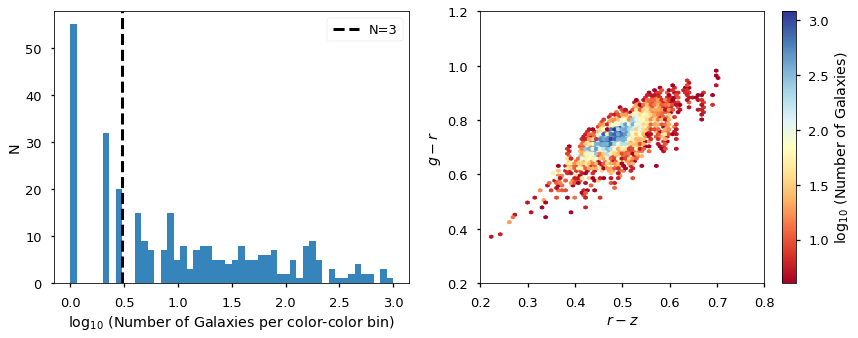

In [63]:
qa_nperbin()

In [66]:
seed = 123
rand = np.random.RandomState(seed)

In [67]:
iarch = list()
good = np.where(count >= mincount)[0]
for gg in good:
    if len(index[gg]) < nperbin:
        iarch.append(index[gg])
    else:
        iarch.append(rand.choice(index[gg], nperbin, replace=False))
iarch = np.hstack(iarch)
resp = count[good]

In [68]:
print('Chose {} templates to represent {} galaxies.'.format(len(iarch), np.sum(resp)))

Chose 1110 templates to represent 48834 galaxies.


In [69]:
def _markers():
    size = 110 * (1+(resp - resp.min()) / resp.ptp())
    shade = (cat['gr'][iarch] - cat['gr'][iarch].min()) / cat['gr'][iarch].ptp()
    col = plt.cm.coolwarm(shade)
    return size, col


In [72]:
def qa_colorcolor():
    """Generate a color-color plot with the symbol size scaled by the responsibility.
    
    """
    size, col = _markers()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.scatter(cat['rzobs'], cat['grobs'], s=30, c='lightgray', edgecolor='k')
    ax1.scatter(cat['rzobs'][iarch], cat['grobs'][iarch], c=col, marker='o', s=size, 
                alpha=1, edgecolor='k')
    ax1.set_xlabel(r'$r - z$')
    ax1.set_ylabel(r'$g - r$')
    ax1.set_ylim(0, 5)
    ax1.grid(True)

    #ax2.scatter(d4000, rz, s=30, c='lightgray', edgecolor='k')
    #ax2.scatter(d4000[iarch], rz[iarch], c=col, marker='o', s=size, 
    #            alpha=1, edgecolor='k')
    #ax2.set_xlabel('$D_{n}(4000)$')
    #ax2.set_ylabel(r'$g - r$')
    #ax2.grid(True)

    fig.subplots_adjust(wspace=0.3)

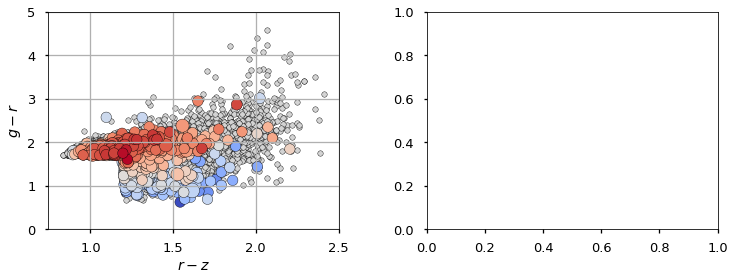

In [73]:
qa_colorcolor()

In [ ]:
len(count)

In [ ]:
lots = np.where(count >= mincount)[0]
nperlots = np.ceil( frac_lots * ntemplate / len(lots) ).astype('int')
print(len(lots), nperlots)

In [ ]:
few = np.where( (count >= 10) * (count < mincount) )[0]
nperfew = np.ceil( (1-frac_lots) * ntemplate / len(few) ).astype('int')
print(len(few), nperfew)

In [ ]:
populated = np.where(count >= mincount)[0]
nperbin = np.ceil( 0.8 * ntemplate / len(populated) ).astype('int')
print(nperbin)
#fracperbin = 0.8 / len(populated)
#fracperbin
#print(populated, count[populated], count[populated] * fracperbin)

In [ ]:
these

In [ ]:
frac_main = 0.8

In [ ]:
ii = 30005
ww = (num == num[ii])
plt.scatter(gr, rz, s=1)
plt.scatter(gr[ii], rz[ii], color='red', s=50)
plt.scatter(gr[ww], rz[ww], color='orange', s=2)
#plt.xlim(0.7, 0.9)
#plt.ylim(0.55, 0.65)

In [ ]:
grbin, rzbin = 0.05, 0.05
ngrbins = np.ceil(np.ptp(grlim) / grbin).astype('int')
nrzbins = np.ceil(np.ptp(rzlim) / rzbin).astype('int')

In [ ]:
num

### Bone-headed search.

In [ ]:
def get_close_templates(zobs, zobs_ages, rmabs, rmabs_ages, gr, gr_ages, 
                       dzmin=0.05, drmabsmin=0.1, dgrmin=0.05):

    dz = zobs[:, None] - zobs_ages[None, :]
    drmabs = rmabs[:, None] - rmabs_ages[None, :]
    dgr = gr[:, None] - gr_ages[None, :]

    close = ((np.abs(dz) < dzmin) * 
             (np.abs(drmabs) < drmabsmin) * 
             (np.abs(dgr) < dgrmin)) * 1

    noneclose = np.where(np.sum(close, axis=1) == 0)[0]
    if len(noneclose) > 0:
        dist = np.sqrt(dz**2 + drmabs**2 + dgr**2)
        nearest = np.argmin(dist[noneclose, :], axis=1)
        close[noneclose, nearest] = 1
    #print(np.where(np.sum(close, axis=1) == 0)) # check we did it right
    
    return close

In [ ]:
def rescale(x, lim=None):
    if lim is not None:
        xscale = (x - lim[0]) / np.ptp(lim)
    else:
        xscale(x - x.min()) / np.ptp(x)
    return xscale

In [ ]:
X = np.vstack((rescale(gr, grlim), rescale(rz, rzlim))).T

In [ ]:
tree = KDTree(X)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
nn = 20
nbrs = NearestNeighbors(n_neighbors=nn, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [ ]:
indices

In [ ]:
gr[indices[ii, :]]

In [ ]:
_ = plt.hist(rescale(Mg-Mr, grlim), bins=100, range=grlim)

In [ ]:
fig, ax = plt.subplots()
_ = ax.hist(kcorr['Z'], bins=100, normed=True)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of Galaxies')